In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 读取CSV文件
data = pd.read_csv("ratings.csv")
#去掉时间戳
data = data.iloc[:, :3]

#打乱数据
data = data.sample(frac=1,random_state=42)

In [4]:
data = data.values.tolist()
# 计算分割点
split_point = int(len(data) * (1 - 0.1))

# 分割数据
train_data = data[:split_point]
test_data = data[split_point:]

In [5]:
def data_dict(data:list[list])->dict[int, dict[int, float]]:
    
    data_dict = {}
    for record in data:
        user = int(record[0])   # 用户名
        movie = int(record[1])  # 电影
        rating = record[2]      # 评分
        if user not in data_dict:
            data_dict[user] = {movie: rating}
        else:
            data_dict[user][movie] = rating
    return data_dict  #数据字典

In [6]:
train_dict = data_dict(train_data)
test_dict =  data_dict(test_data)

In [7]:
def AVG(train_matrix):
    # 创建一个空字典来存储每个用户的平均评分
    avg_array = {}
    # 遍历外层字典中的每个用户
    for user, movie_ratings in train_matrix.items():
        # 计算该用户对所有电影的评分平均值
        avg_rating = sum(movie_ratings.values()) / len(movie_ratings)
        avg_array[user] = avg_rating
    return avg_array

In [8]:
avg_array = AVG(train_dict)

In [10]:
def calculate_pearson_correlation(x, y):
    # 计算两个变量的平均值
    mean_x = sum(x) / len(x)
    mean_y = sum(y) / len(y)
    
    
    # 计算相关性的分子和分母
    numerator = sum((x[i] - mean_x) * (y[i] - mean_y) for i in range(len(x)))
    denominator_x = sum((x[i] - mean_x) ** 2 for i in range(len(x)))
    denominator_y = sum((y[i] - mean_y) ** 2 for i in range(len(x)))

    # 计算皮尔逊相关性
    if denominator_x == 0 or denominator_y == 0:
        return 0  # 避免除以零
    else:
        correlation = numerator / ((denominator_x*denominator_y)**0.5)
        return correlation

In [11]:
def Slope(x, y):
    
    # 计算相关性的分子
    slope = 0
    for i in range(len(x)):
        numerator=x[i]-y[i]
        denominator=len(x)
        slope+=numerator/denominator

    return slope

In [12]:
'''
计算相似性
'''
def calculate_user_similarity(train_matrix):
    #设定阈值
    th=0
    
    
    #初始化相似度字典
    user_similarity = {}
    
    # 获取用户数
    num_users = train_matrix.keys()
    
    # 遍历用户i
    for i in num_users:
        for j in num_users:
            if i<= j:   # 只计算上三角部分
                continue
           
            # 找到两个用户共同评价过的电影
            common_movies = set(train_matrix[i].keys()) & set(train_matrix[j].keys())

            if len(common_movies)==0:
                continue
                
            # 提取共同电影的评分
            ratings_i = [train_matrix[i][movie] for movie in common_movies]
            ratings_j = [train_matrix[j][movie] for movie in common_movies]

            # 计算皮尔逊相关系数
            correlation = calculate_pearson_correlation(ratings_i, ratings_j)
            
            if correlation>th:
                # 计算皮尔逊相关系数
                distence = Slope(ratings_i, ratings_j)
                if i in user_similarity :
                    user_similarity [i][j] = distence
                else:
                    d ={j:distence}
                    user_similarity [i] = d
                if j in user_similarity  :
                    user_similarity [j][i] = -1*distence
                else:
                    d ={i:-1*distence}
                    user_similarity [j] = d

            
           
    return user_similarity

In [13]:
sim_matrix = calculate_user_similarity(train_dict)

In [15]:
'''
预测
'''
def predict(train_dict,test_dict,sim_matrix,avg_array):
    predict_dict = {}
    for user in test_dict.keys():
        predict_movies = test_dict[user].keys()   
        
#          # 如果用户没有邻居，取平均值作为预测值
#         if user not in neighbor_dict.keys():
#             predict_dict[user] = {movie: avg_array[user] for movie in predict_movies}
#             continue

        # 如果用户不在训练集中，预测为3.5
        if user not in train_dict.keys():
            predict_dict[user] = {movie: 3.5 for movie in predict_movies}
            continue
        if user not in sim_matrix.keys():
            predict_dict[user] = {movie: avg_array[user] for movie in predict_movies}  
            
            continue
       
        neighbors = sim_matrix[user] 
        # 遍历需要预测的电影
        for movie in predict_movies:
            predict_rating=[]
            # 遍历邻居
            for neighbor in neighbors:
                if movie not in train_dict[neighbor].keys():   #电影不在训练集
                    continue
                
                similarity = sim_matrix[user][neighbor]        #相似性为None
                
                if similarity is None:
                    continue

#                 neighbors_now += 1
#                 numerator += similarity * (train_dict[neighbor][movie] - avg_array[neighbor])
#                 denominator += abs(similarity)
#                 if neighbors_now >= neighbor_num:            #邻居数大于预定的
#                     break

                predict_rating.append(train_dict[neighbor][movie] + sim_matrix[user][neighbor])
                predict_rating_sum=sum(predict_rating)/len(predict_rating)if len(predict_rating) != 0 else avg_array[user]
                predict_dict.setdefault(user, {})[movie] = predict_rating_sum

    return predict_dict


In [16]:
def calculate_mae(predict_dict, true_dict):
    mae = 0
    count = 0

    for user, movies in true_dict.items():
        for movie, true_rating in movies.items():
            if user in predict_dict and movie in predict_dict[user]:
                predicted_rating = predict_dict[user][movie]
                mae += abs(predicted_rating - true_rating)
                count += 1

    if count == 0:
        return 0
    return mae / count

In [17]:
import numpy as np
def calculate_rmse(predict_dict, true_dict):
    mae = 0
    count = 0

    for user, movies in true_dict.items():
        for movie, true_rating in movies.items():
            if user in predict_dict and movie in predict_dict[user]:
                predicted_rating = predict_dict[user][movie]
                mae += (predicted_rating - true_rating)**2
                count += 1

    if count == 0:
        return 0
    return np.sqrt(mae / count)

In [18]:
#计算accuracy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def class_accuracy(predict_dict,test_dict): 
    result_p= []
    result_t= []
    for user,movies in predict_dict.items():
        for movie in movies.keys():
            if np.isnan(predict_dict[user][movie]):
                continue
            result_p.append(predict_dict[user][movie])
            result_t.append(test_dict[user][movie])
            
            
    #数据处理（>平均值为1，<为0）
    # 计算列表的平均值
    average_p = sum(result_p) / len(result_p)
    average_t = sum(result_t) / len(result_t)
    
    # 遍历列表并更新元素
    for i in range(len(result_p)):
        if result_p[i] > average_p:
            result_p[i] = 1
        else:
            result_p[i] = 0
    
    for i in range(len(result_t)):
        if result_t[i] > average_t:
            result_t[i] = 1
        else:
            result_t[i] = 0
    # 计算准确率
    accuracy = accuracy_score(result_t, result_p)
    return accuracy

In [19]:
#计算precision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def class_precision(predict_dict,test_dict): 
    result_p= []
    result_t= []
    for user,movies in predict_dict.items():
        for movie in movies.keys():
            if np.isnan(predict_dict[user][movie]):
                continue
            result_p.append(predict_dict[user][movie])
            result_t.append(test_dict[user][movie])
    #数据处理（>平均值为1，<为0）
    # 计算列表的平均值
    average_p = sum(result_p) / len(result_p)
    average_t = sum(result_t) / len(result_t)
    
    # 遍历列表并更新元素
    for i in range(len(result_p)):
        if result_p[i] > average_p:
            result_p[i] = 1
        else:
            result_p[i] = 0
    
    for i in range(len(result_t)):
        if result_t[i] > average_t:
            result_t[i] = 1
        else:
            result_t[i] = 0
    # 计算准确率
    precision = precision_score(result_t, result_p)
    return precision

In [20]:
#计算recall

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def class_recall(predict_dict,test_dict): 
    result_p= []
    result_t= []
    for user,movies in predict_dict.items():
        for movie in movies.keys():
            if np.isnan(predict_dict[user][movie]):
                continue
            result_p.append(predict_dict[user][movie])
            result_t.append(test_dict[user][movie])
    
    #数据处理（>平均值为1，<为0）
    # 计算列表的平均值
    average_p = sum(result_p) / len(result_p)
    average_t = sum(result_t) / len(result_t)
    
    # 遍历列表并更新元素
    for i in range(len(result_p)):
        if result_p[i] > average_p:
            result_p[i] = 1
        else:
            result_p[i] = 0
    
    for i in range(len(result_t)):
        if result_t[i] > average_t:
            result_t[i] = 1
        else:
            result_t[i] = 0
    # 计算准确率
    recall = recall_score(result_t, result_p)
    return recall

In [21]:
#计算f1

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def class_f1(predict_dict,test_dict): 
    result_p= []
    result_t= []
    for user,movies in predict_dict.items():
        for movie in movies.keys():
            if np.isnan(predict_dict[user][movie]):
                continue
            result_p.append(predict_dict[user][movie])
            result_t.append(test_dict[user][movie])
    
    #数据处理（>平均值为1，<为0）
    # 计算列表的平均值
    average_p = sum(result_p) / len(result_p)
    average_t = sum(result_t) / len(result_t)
    
    # 遍历列表并更新元素
    for i in range(len(result_p)):
        if result_p[i] > average_p:
            result_p[i] = 1
        else:
            result_p[i] = 0
    
    for i in range(len(result_t)):
        if result_t[i] > average_t:
            result_t[i] = 1
        else:
            result_t[i] = 0
    # 计算准确率
    f1 = f1_score(result_t, result_p)#precision = precision_score(result_t, result_p, average='None')

    return f1

In [22]:
import math
def per_NDCG(predict_dict,test_dict):
       
    dcgs=[]
    for user,movies in predict_dict.items():
        result_p_u= []
        result_t_u= []
        for movie in movies.keys():
            if np.isnan(predict_dict[user][movie]):
                continue
            result_p_u.append(predict_dict[user][movie])
            result_t_u.append(test_dict[user][movie])
        
        if not result_t_u:
            continue
        
        
        #每一行计算，用户
        average_t_u = sum(result_t_u) / len(result_t_u)
        #推荐列表由大到小排序
        
        # 使用enumerate获取原列表元素及其索引，然后按元素值排序
        sorted_p = sorted(enumerate(result_p_u), key=lambda x: x[1], reverse=True)  

        # 从排序后的元组列表中提取索引
        sorted_p = [index for index, value in sorted_p]   #生成的列表是一个索引列表
        #sorted_t_u = sorted(result_t_u, reverse=True)
        # 遍历列表并更新元素
        #print(sorted_p)


        for i in range(len(result_t_u)):
            if result_t_u[i] > average_t_u:
                result_t_u[i] = 1
            else:
                result_t_u[i] = 0
        dcg=0
    
        for i in sorted_p:
            if i < 2:
                dcg=result_t_u[i]+dcg
                #print(11)
            else :
                logs=math.log(i,2) 
                if logs==0:
                    logs=1
                dcg=result_t_u[i]/logs+dcg
                #print(22)
            dcgs.append(dcg)
    dcgs_max=max(dcgs)
    x=0   #分子
    for i in range(len(dcgs)):
        x=dcgs[i]/dcgs_max+x
    ndcg=x/len(dcgs)
    return ndcg
        

In [23]:
# 7. 计算k个邻居时的平均绝对误差并画出误差曲线
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,15,20,30,40,50]
mae_values = []
rmse_values = []
accuracys = []
precisions = []
recalls = []
f1s = []
hlus= []
ndcgs =[]
for k in k_values:
    
    predict_dict = predict(train_dict,test_dict,sim_matrix,avg_array)
    mae =calculate_mae(predict_dict,test_dict)
    rmse =calculate_rmse(predict_dict,test_dict)
    accuracy=class_accuracy(predict_dict,test_dict)
    mae_values.append(mae)
    rmse_values.append(rmse)

    #分类
    accuracy=class_accuracy(predict_dict,test_dict)
    accuracys.append(accuracy)

    
    precision=class_precision(predict_dict,test_dict)
    precisions.append(precision)

    
    recall=class_recall(predict_dict,test_dict)
    recalls.append(recall)

          
    f1=class_f1(predict_dict,test_dict)
    f1s.append(f1)

    
    ndcg=per_NDCG(predict_dict,test_dict)
    ndcgs.append(ndcg)


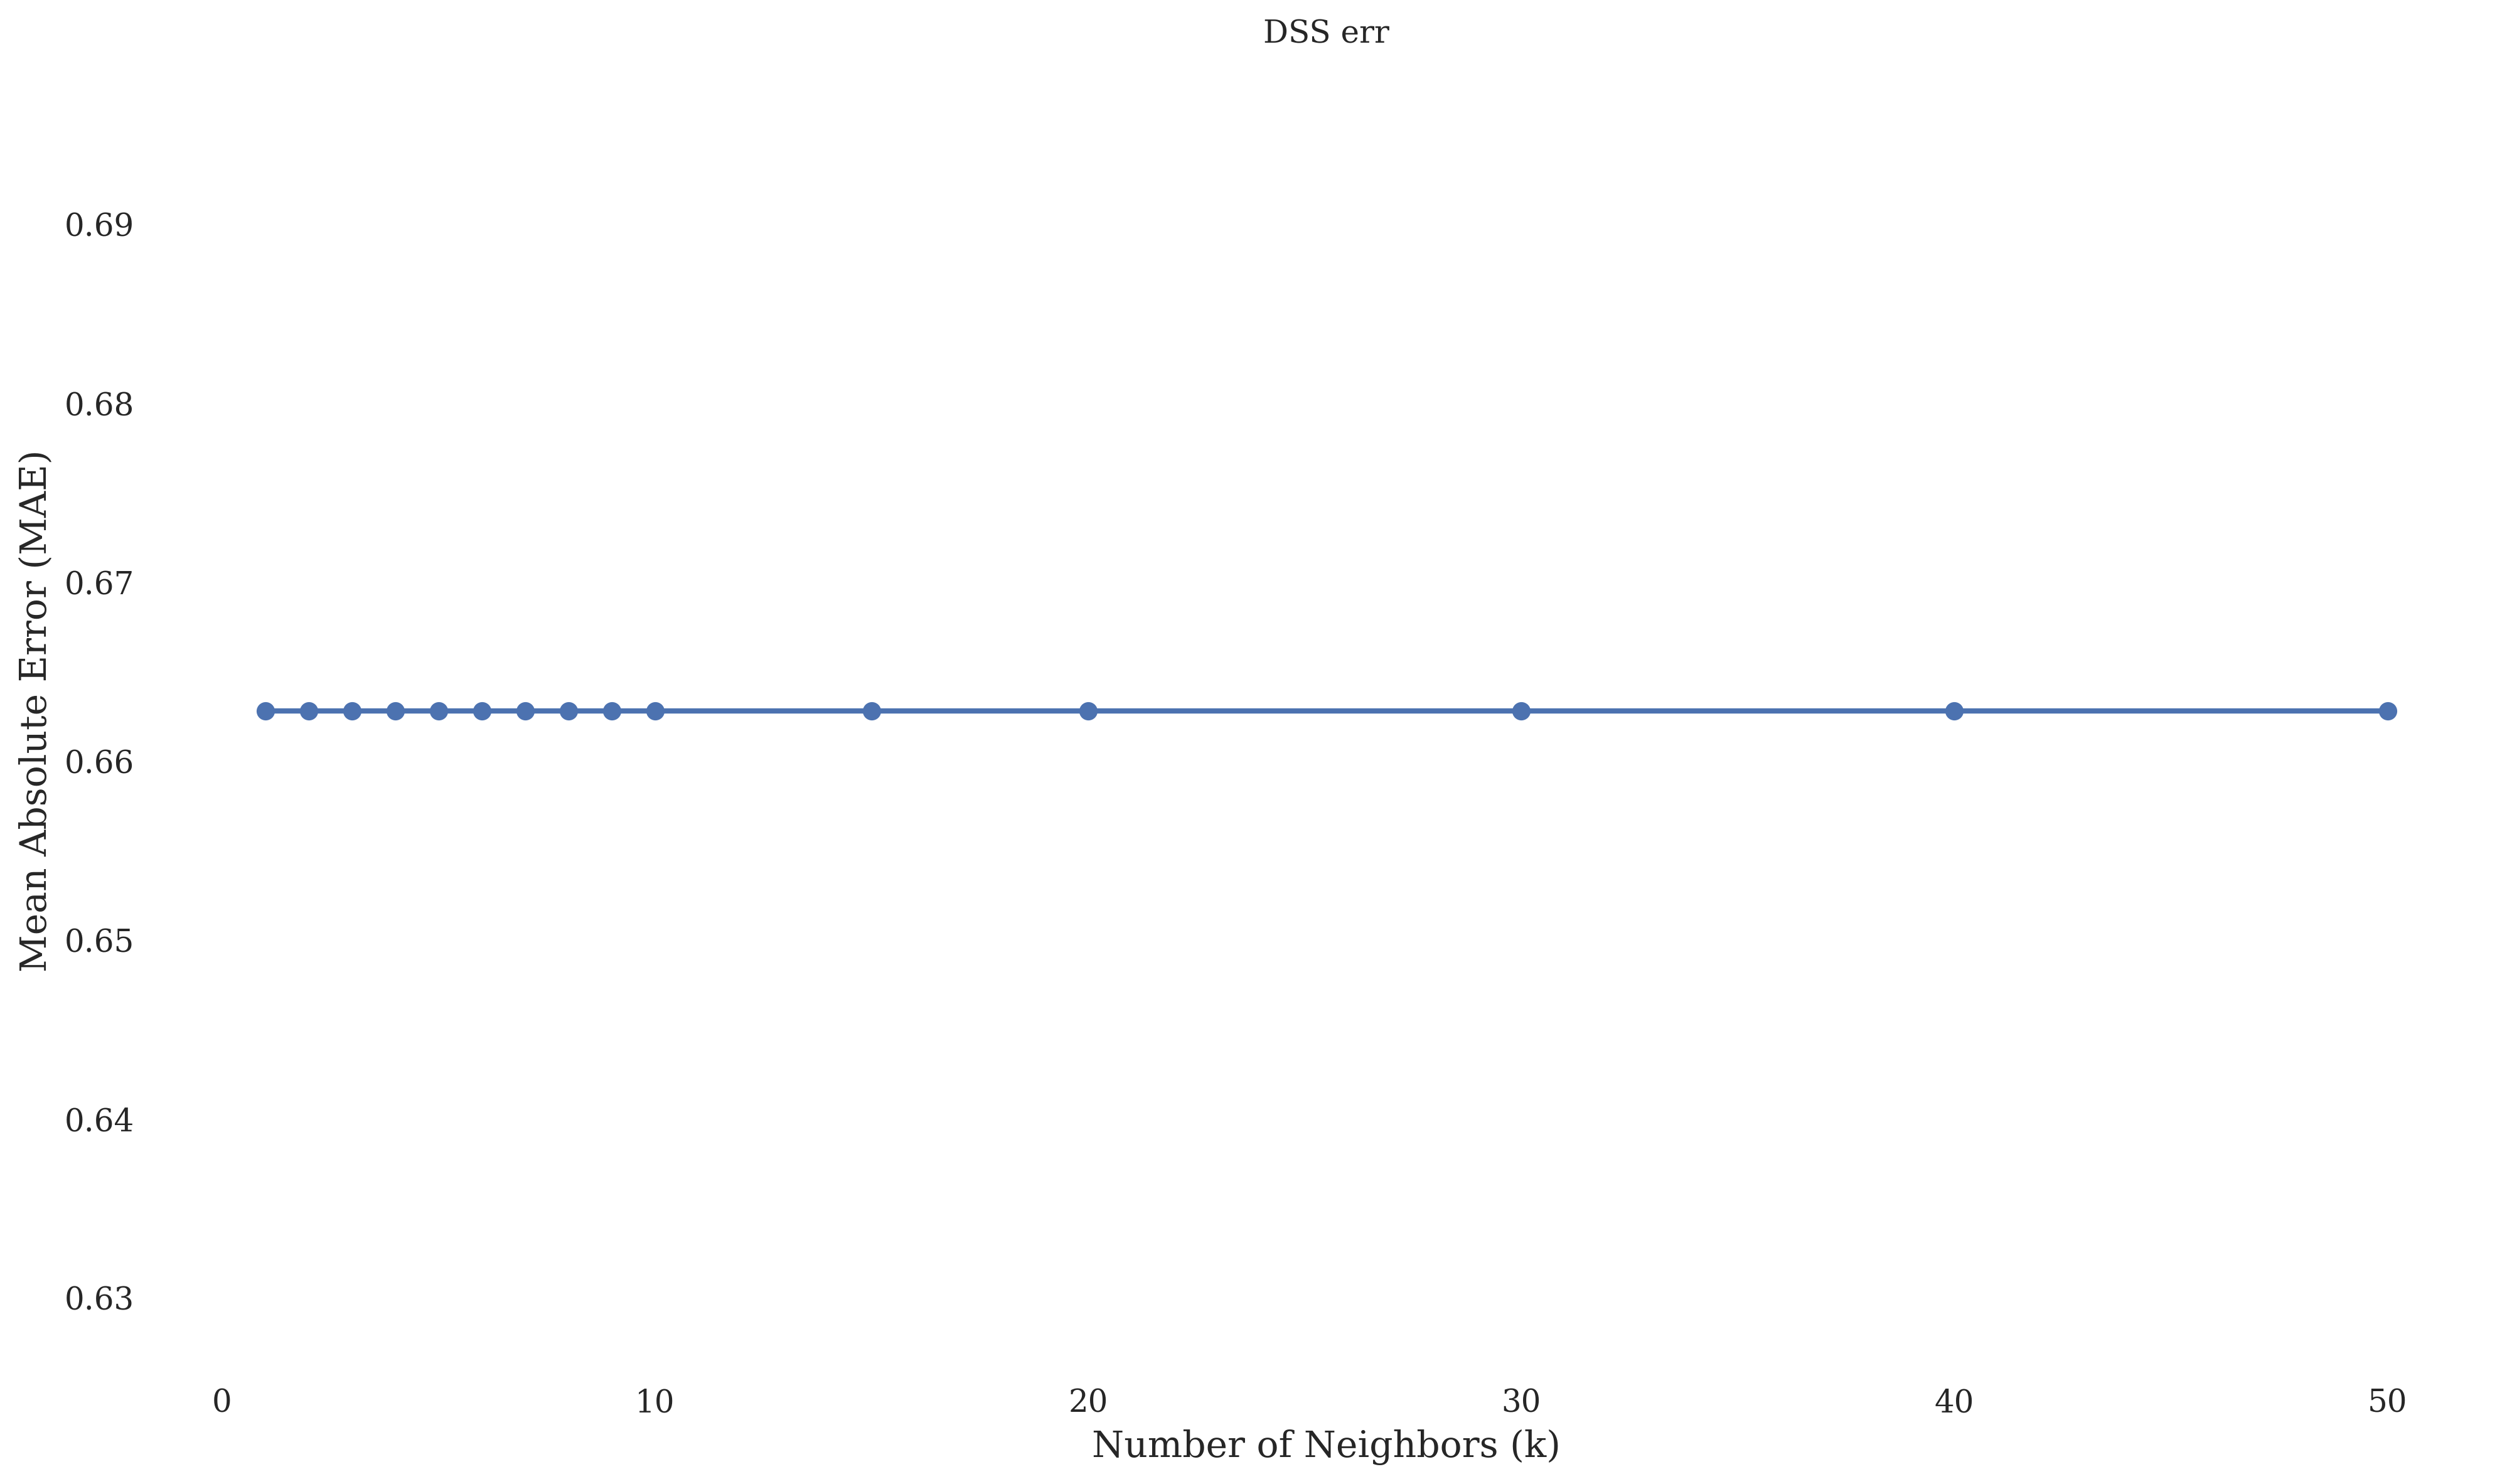

In [24]:
# 画出误差曲线
rcParameters = {
        'axes.unicode_minus': False,
        "figure.figsize": [16, 9],
        "figure.dpi": 300,
        'font.family': 'serif',
        'font.size': 14,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'lines.linewidth': 2,
        'axes.grid': True,
        'grid.alpha': 0.5,
        'axes.facecolor': 'white'
    }
sns.set(rc=rcParameters)
plt.plot(k_values, mae_values, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('DSS err')
plt.show()

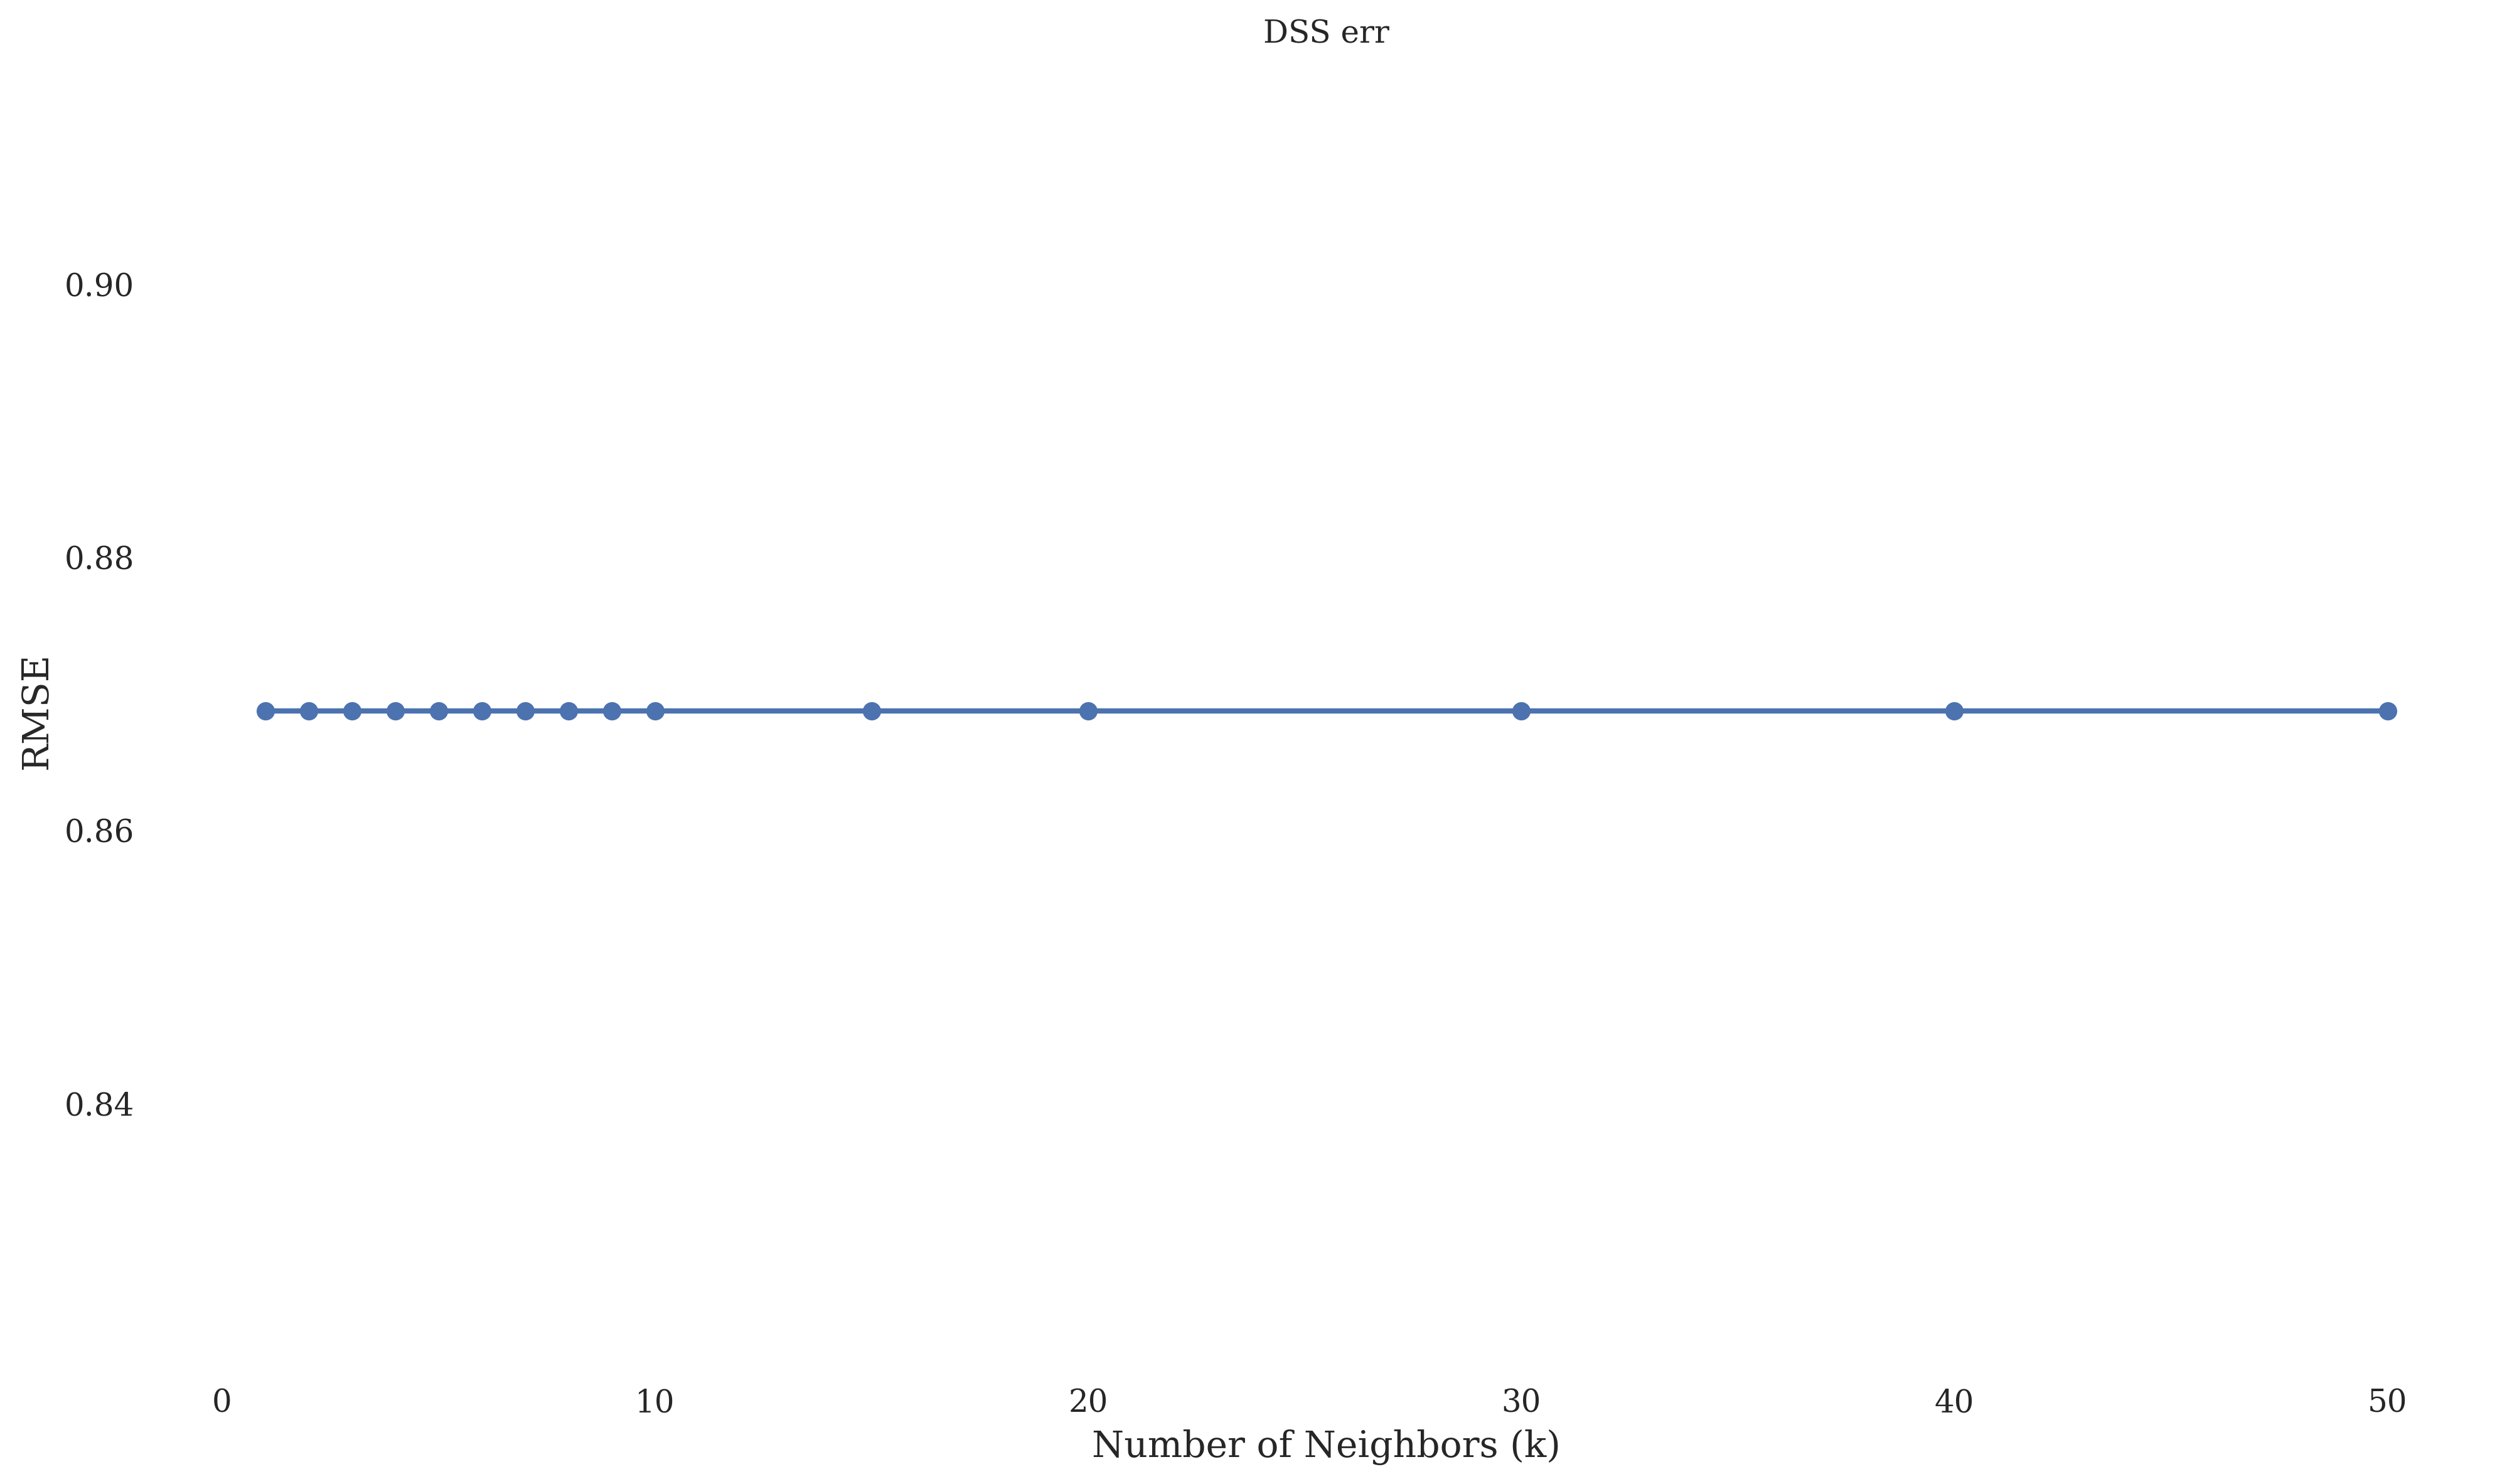

In [25]:
# 画出误差曲线
rcParameters = {
    'axes.unicode_minus': False,
    "figure.figsize": [16, 9],
    "figure.dpi": 300,
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'axes.grid': True,
    'grid.alpha': 0.5,
    'axes.facecolor': 'white'
}
sns.set(rc=rcParameters)

plt.plot(k_values,rmse_values, marker='o')

plt.xlabel('Number of Neighbors (k)')

plt.ylabel('RMSE')

plt.title('DSS err')

plt.show()

C:\Users\l2310\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


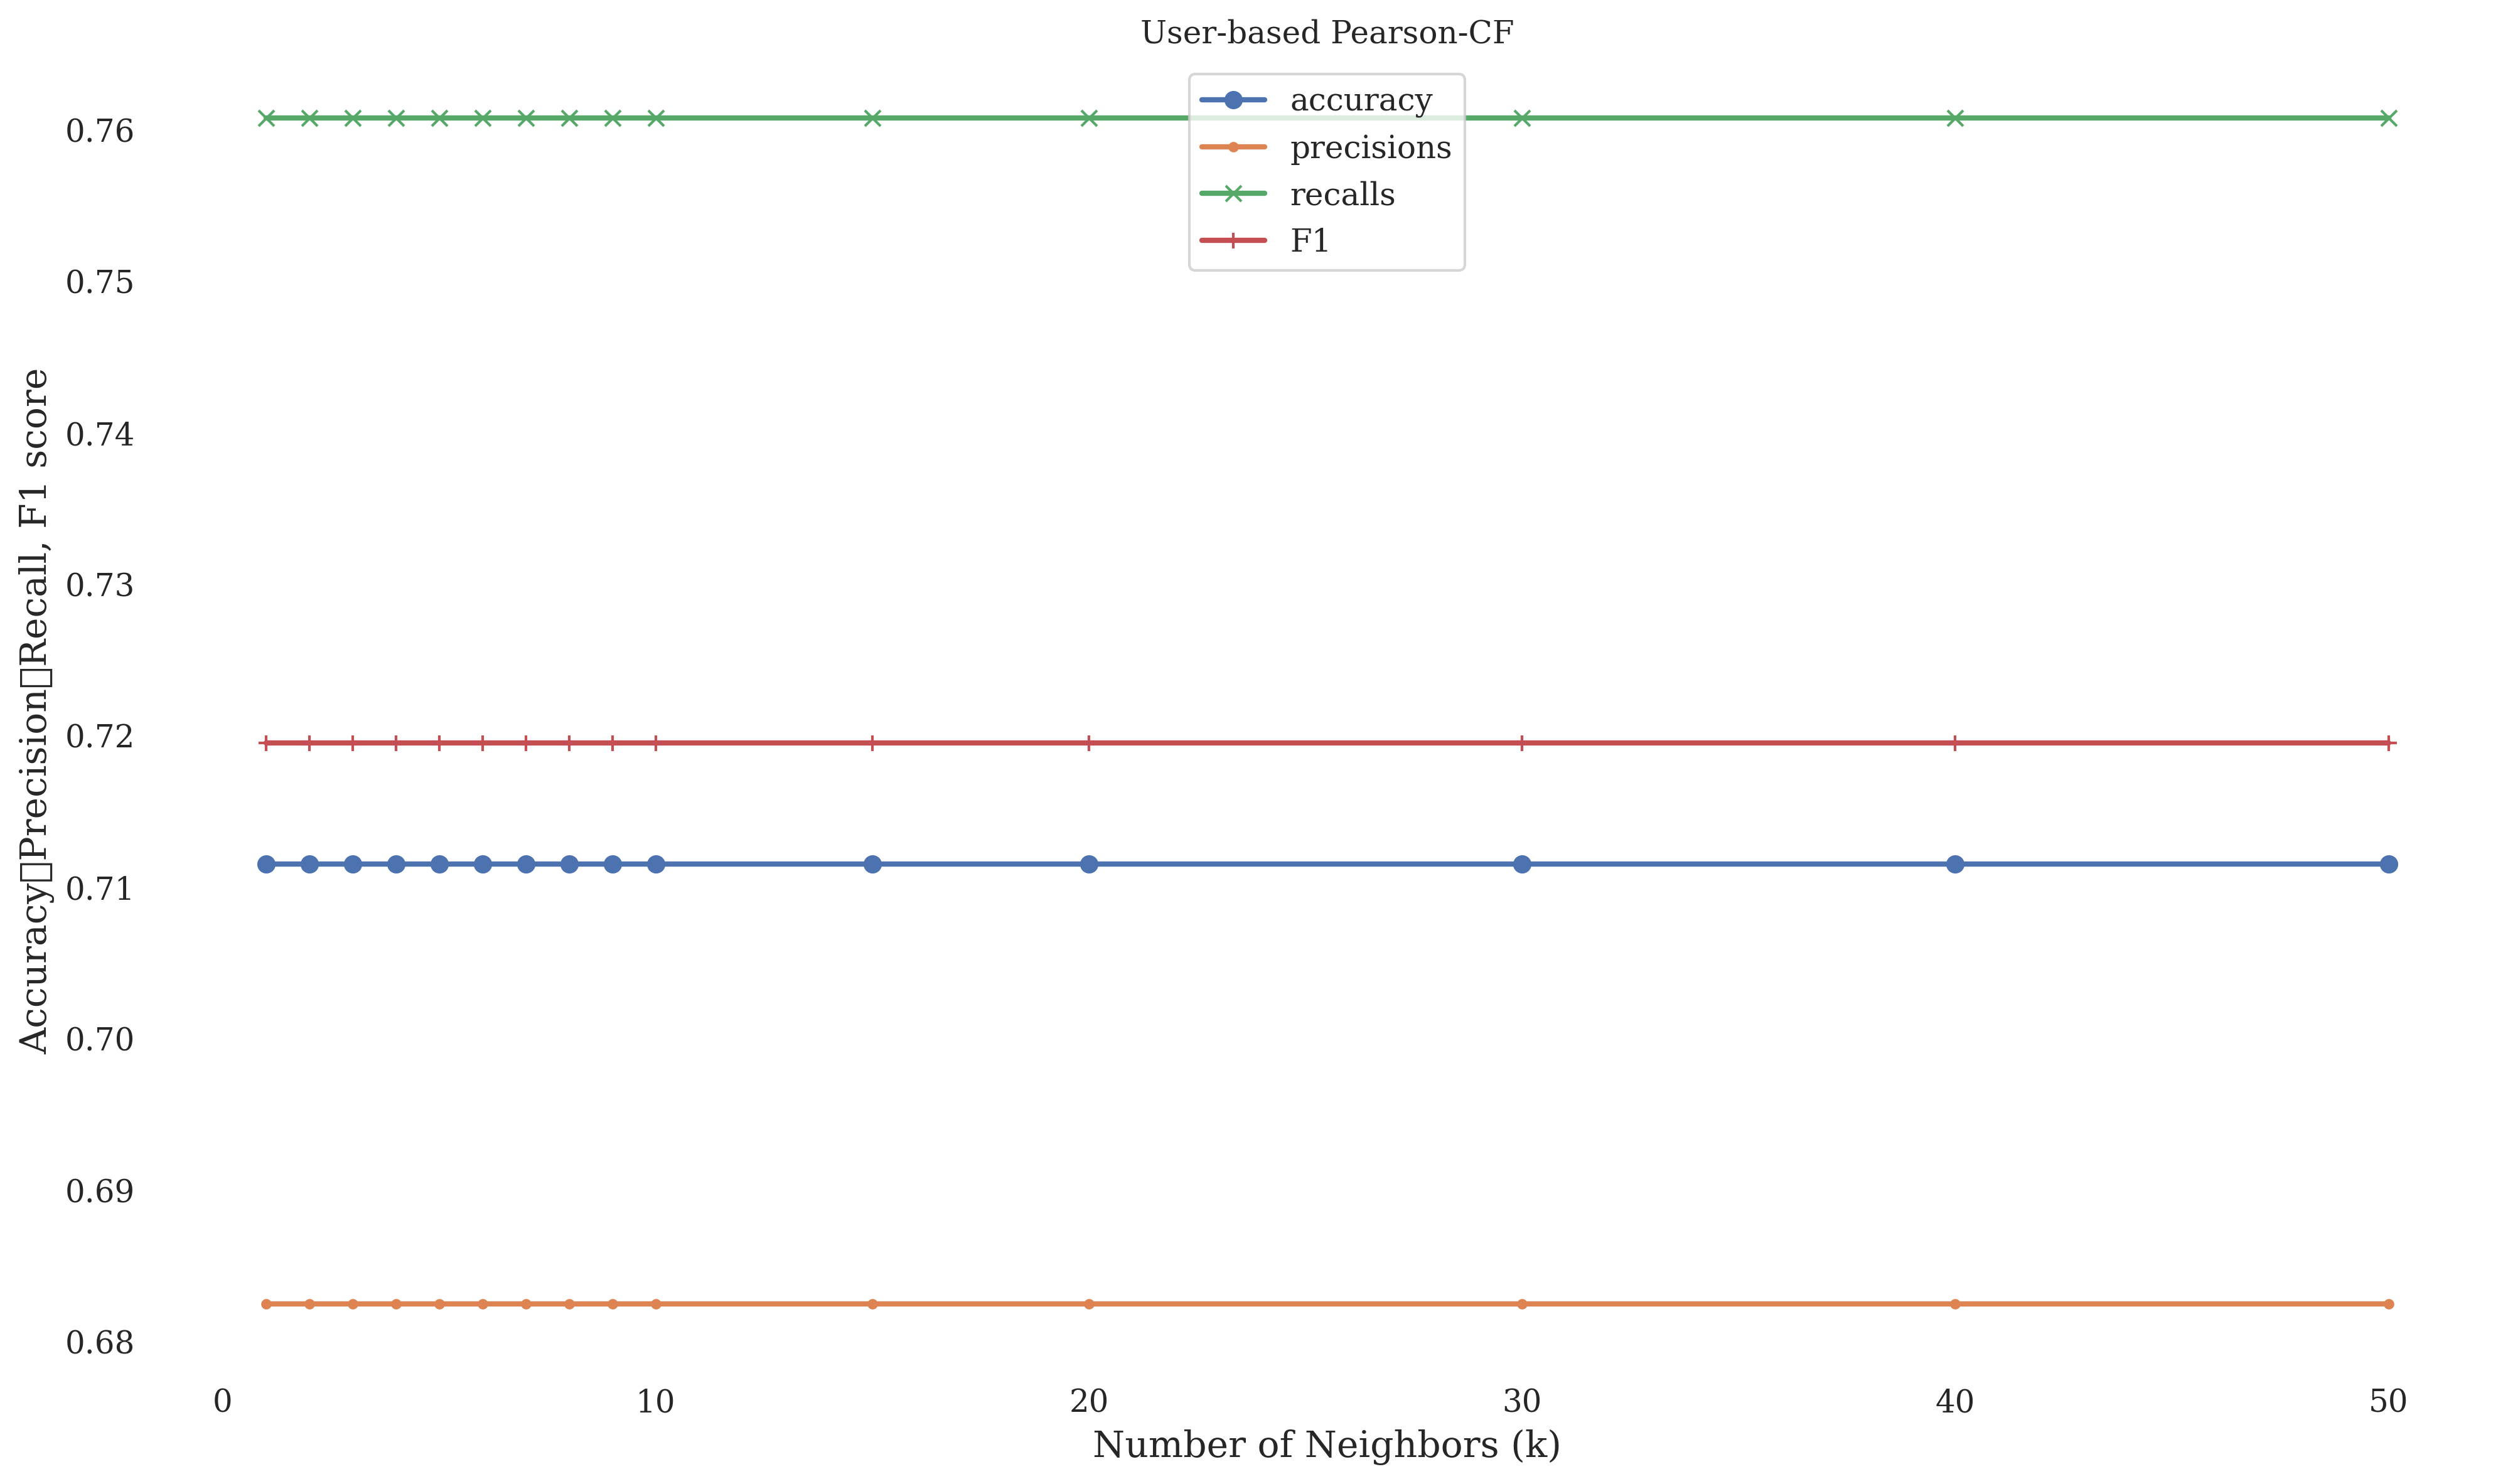

In [26]:
rcParameters = {
    'axes.unicode_minus': False,
    "figure.figsize": [16, 9],
    "figure.dpi": 300,
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'axes.grid': True,
    'grid.alpha': 0.5,
    'axes.facecolor': 'white'
}
sns.set(rc=rcParameters)

plt.plot(k_values,accuracys, marker='o',label='accuracy')

plt.plot(k_values, precisions, marker='.',label='precisions') 

plt.plot(k_values, recalls, marker='x',label='recalls')

plt.plot(k_values, f1s, marker='+',label='F1')

plt.xlabel('Number of Neighbors (k)')

plt.ylabel('Accuracy，Precision，Recall, F1 score')

plt.title('User-based Pearson-CF')

plt.legend(loc='upper center')  # 添加图例  

plt.show()

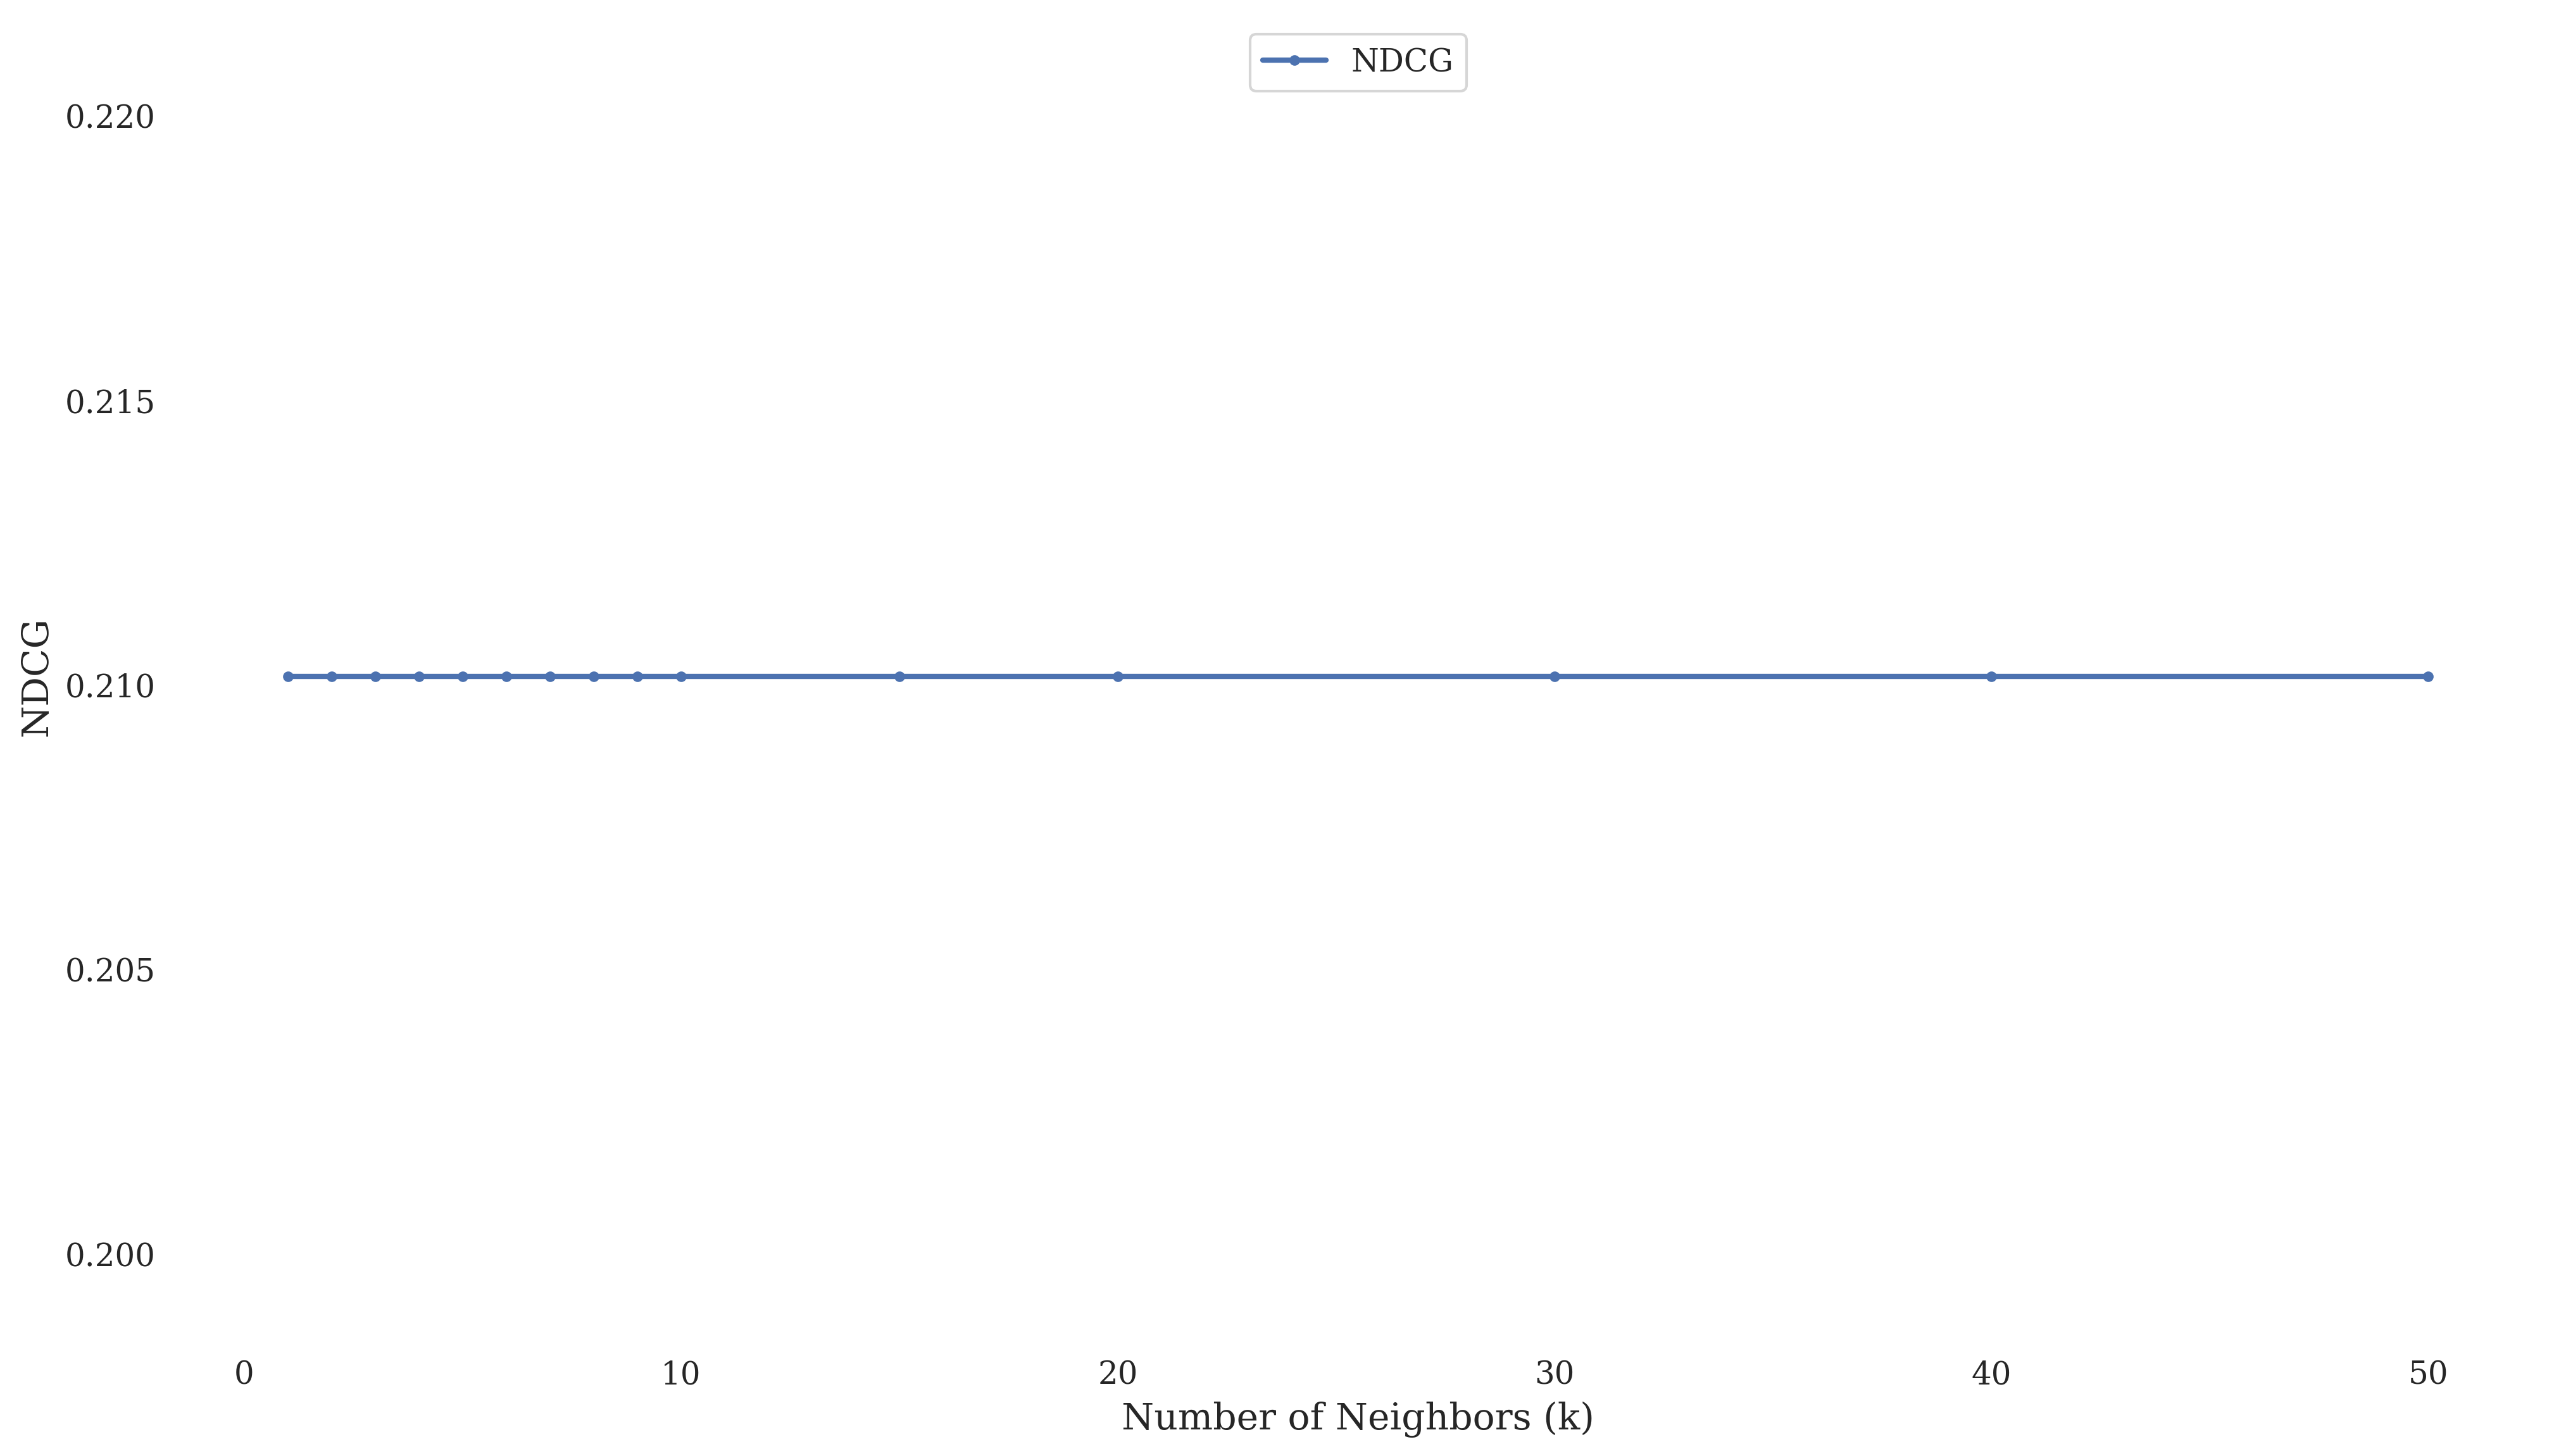

In [27]:
rcParameters = {
    'axes.unicode_minus': False,
    "figure.figsize": [16, 9],
    "figure.dpi": 300,
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'axes.grid': True,
    'grid.alpha': 0.5,
    'axes.facecolor': 'white'
}
sns.set(rc=rcParameters)

plt.plot(k_values, ndcgs, marker='.',label='NDCG') 

plt.xlabel('Number of Neighbors (k)')

plt.ylabel('NDCG')

plt.legend(loc='upper center')  # 添加图例  

plt.show()